In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.optim as optim
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
import sys
sys.path.append("../pyfiles/")
from util import weights_init, cuda2numpy, do_test_VAE, image_from_output, image_from_numpy
from dataset import transform, Dataset_MNIST
from model import VAE

In [3]:
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

# References
- [What is Anomaly Detection? Examining the Essentials](https://www.anodot.com/blog/what-is-anomaly-detection/)

# Introduction
---
今回の宿題では，オートエンコーダを用いた異常検知を行なってもらいます．
異常検知とは，その言葉の通り異常を検知するシステムのことである．
この"異常"とは様々なことが考えられる．
例えば，アプリの性能低下などから，もっとシンプルに「いつも真顔の人の笑顔」とかも考えられる．
つまり，異常とは正常（と定義した事柄）からの逸脱を表し，この定義が重要になる．
これ以上に詳しく知りたい方は，上のリンクをクリックしてください．

今回皆さんに編集してもらい部分は，正常データをどのクラスを指定する次のセルのみです．
ここで指定したクラス以外のクラスは異常データとして扱います．
その後はノートブックを実行していき，時々にある演習を解答していきましょう．
問題数は全部合わせて，5つあります．

---

In [5]:
# ----- adjustable parameters ----- #
source_number = 4 # put one of the numbers :[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# --------------------------------- #

### Preparation
- Models
    - *bfeatures*: 隠れ層(hidden layer)の特徴量数を表すパラメタ，大きいほどモデルの複雑度が増す．
    - *n_layers*: エンコーダとデコーダの層の深さを決定するパラメタ
    - *z_dim*: 潜在ベクトル(latent code)の次元数を決定するパラメタ
    
    
- Training
    - optimizer: Adam optimizer, デフォルトのパラメタ
    - scheduler: 学習率が指数関数的に減少するスケジューラ

In [9]:
# Models
bfeatures = 16
n_layers = 3
z_dim = 3
device = "cpu"
net = VAE(z_dim=z_dim, nch_input=1, nch=bfeatures, device=device, image_shape=(16, 16), n_layers=n_layers).to(device)
net.apply(weights_init)

# Training
lr = 0.001 # learning rate
epoch_num = 501 # the number of epochs
save_parameter = True # do you wanna save parameters ?
test_interval = 3 # the interval among validation check
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

# Dataset
root = "../dataset/MNIST/"
train_batch = 32
val_batch = 32
each_datanum = 1000
numbers = tuple(list([source_number])) 
dataset = Dataset_MNIST(root, numbers, "train", transform["train"], each_datanum=each_datanum)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=train_batch, shuffle=True)
valset = Dataset_MNIST(root, numbers, "val", transform["test"], each_datanum=each_datanum)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=val_batch, shuffle=False)
fixed_image = dataset[100][0].unsqueeze(0)

## Training
---
では、異常検知として使うモデルを訓練してみましょう。
このセルにはエポックごとのロスと，訓練サンプルと検証サンプルの再構成結果を出すようにしてます。
そして、検証用データにおいての一番いいエポックを記憶するようにしているので、後に呼び出してみましょう。

---
Let's train your model.
The notebook shows you the losses and the accuracies in every epoch.
What's more, it'll store the best epoch for the validation dataset, so you can call it when the training is finished.

---

500
test loss in 498 : 31.830841064453125
best loss is   : 31.35713768005371 in epoch426


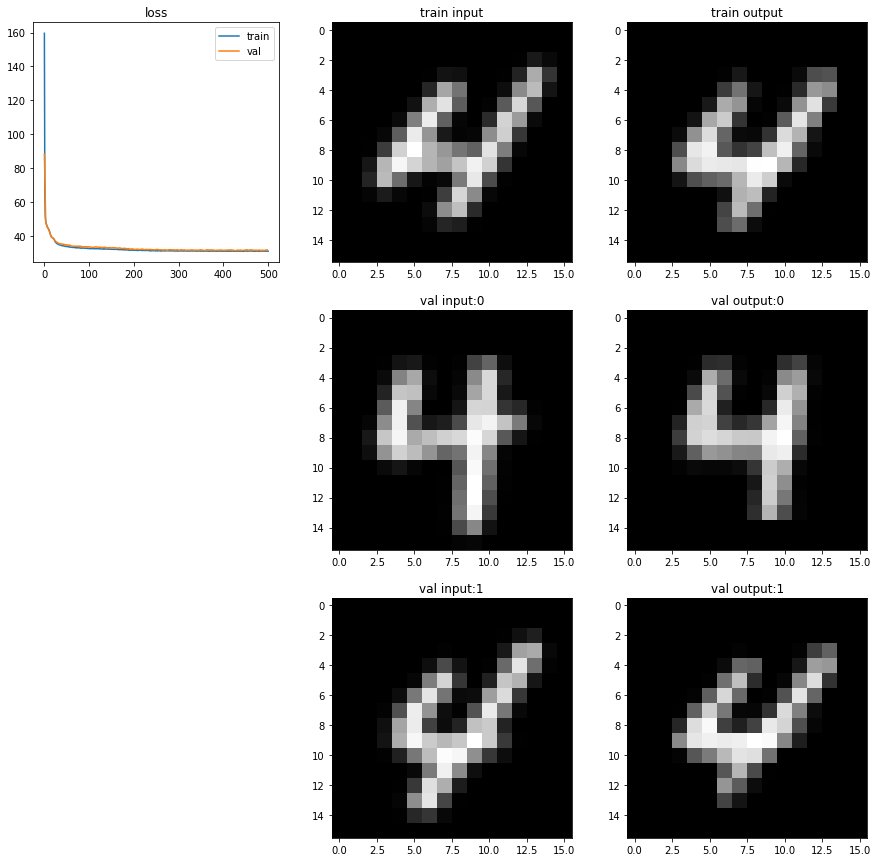

In [10]:
train = True

if train:
    losses_epoch = []
    losses_epoch_test = []
    best_epoch = 0
    best_loss = np.inf
    for epoch in range(epoch_num):
        losses = []
        for itr, data in enumerate(dataloader):
            net.train()
            x = data[0].to(device)
            label = data[1].to(device)
            optimizer.zero_grad()
            _, _, loss = net(x, True)
            loss.backward()
            optimizer.step()

            loss = loss.to("cpu").detach().numpy()
            label = label.to("cpu").detach().numpy()
            losses.append(loss)
        losses_epoch.append(np.mean(np.array(losses)))
        scheduler.step()
        if epoch%test_interval==0:
            labels, inputs, outputs, loss_test, latents = do_test_VAE(net, valloader, device, "eval")
            losses_epoch_test.append(loss_test)
            if best_loss > loss_test:
                best_loss = loss_test
                best_epoch = epoch

        clear_output(wait=True)
        print(epoch)
        print(f"test loss in {epoch//test_interval*test_interval} : {loss_test}")
        print(f"best loss is   : {best_loss} in epoch{best_epoch}")
        if save_parameter:
            if epoch%test_interval==0:
                torch.save(net.state_dict(), 
                           f"../instant_parameters/VAE_MNIST_ndim{z_dim}_nch{bfeatures}_lr{lr}_source{source_number}_epoch{epoch}.pth")

        width = 3
        val_num = 2
        height = 1 + val_num

        fig = plt.figure(figsize=(5*width,5*height))
        ax = fig.add_subplot(height,width,1)
        ax.plot(losses_epoch, label="train")
        ax.plot(np.arange(epoch//test_interval+1)*test_interval, losses_epoch_test, label="val")
        ax.legend()
        ax.set_title('loss')
        net.eval()
        fixed_output, _ = net(fixed_image)

        ax = fig.add_subplot(height,width,2)
        M = image_from_output(fixed_image)[0]
        ax.imshow(M)
        ax.set_title("train input")
        ax = fig.add_subplot(height,width,3)
        M = image_from_output(fixed_output)[0]
        ax.imshow(M)
        ax.set_title("train output")
        for i in range(val_num):
            ax = fig.add_subplot(height,width,3+i*3+2)
            idx = len(valset)//val_num*i
            M = image_from_output(torch.tensor(inputs[idx:idx+1]))[0]
            ax.imshow(M)
            ax.set_title(f"val input:{i}")
            ax = fig.add_subplot(height,width,3+i*3+3)
            M = image_from_output(torch.tensor(outputs[idx:idx+1]))[0]
            ax.imshow(M)
            ax.set_title(f"val output:{i}")
        plt.show()

## Result
---
では出力結果をみて、一番いいエポックを確認してみましょう。
そのあと、`load_epoch`に代入してください。

---
Ok, next, please look at the output of the last cell and note the best epoch as illustrated below. 
And put the epoch into `load_epoch` in the cell below.

<img src="./../data/images/result.png" width="600">


---

In [11]:
# ----- adjustable parameters ----- #
load_epoch = 426
# --------------------------------- #

dir = f"../instant_parameters/"
load_parameter = True
if load_parameter:
    model_path = f"{dir}VAE_MNIST_ndim{z_dim}_nch{nch}_lr{lr}_source{source_number}_epoch{load_epoch}.pth"
    model = torch.load(model_path)
    net.load_state_dict(model)

## Anomaly Detection
---
では，異常検知をしていきましょう．
オートエンコーダを用いてどのように異常検知するのかが最後の演習になるので，それを踏まえて進んでいきましょう．

---

### Reconstructed Images
---
では，まずは再構成の結果を見てみましょう．
最初は`source_number`で設定した正常なクラスのデータセットにおける結果を見ていきます．
上が入力データで下が再構築したデータです．

---

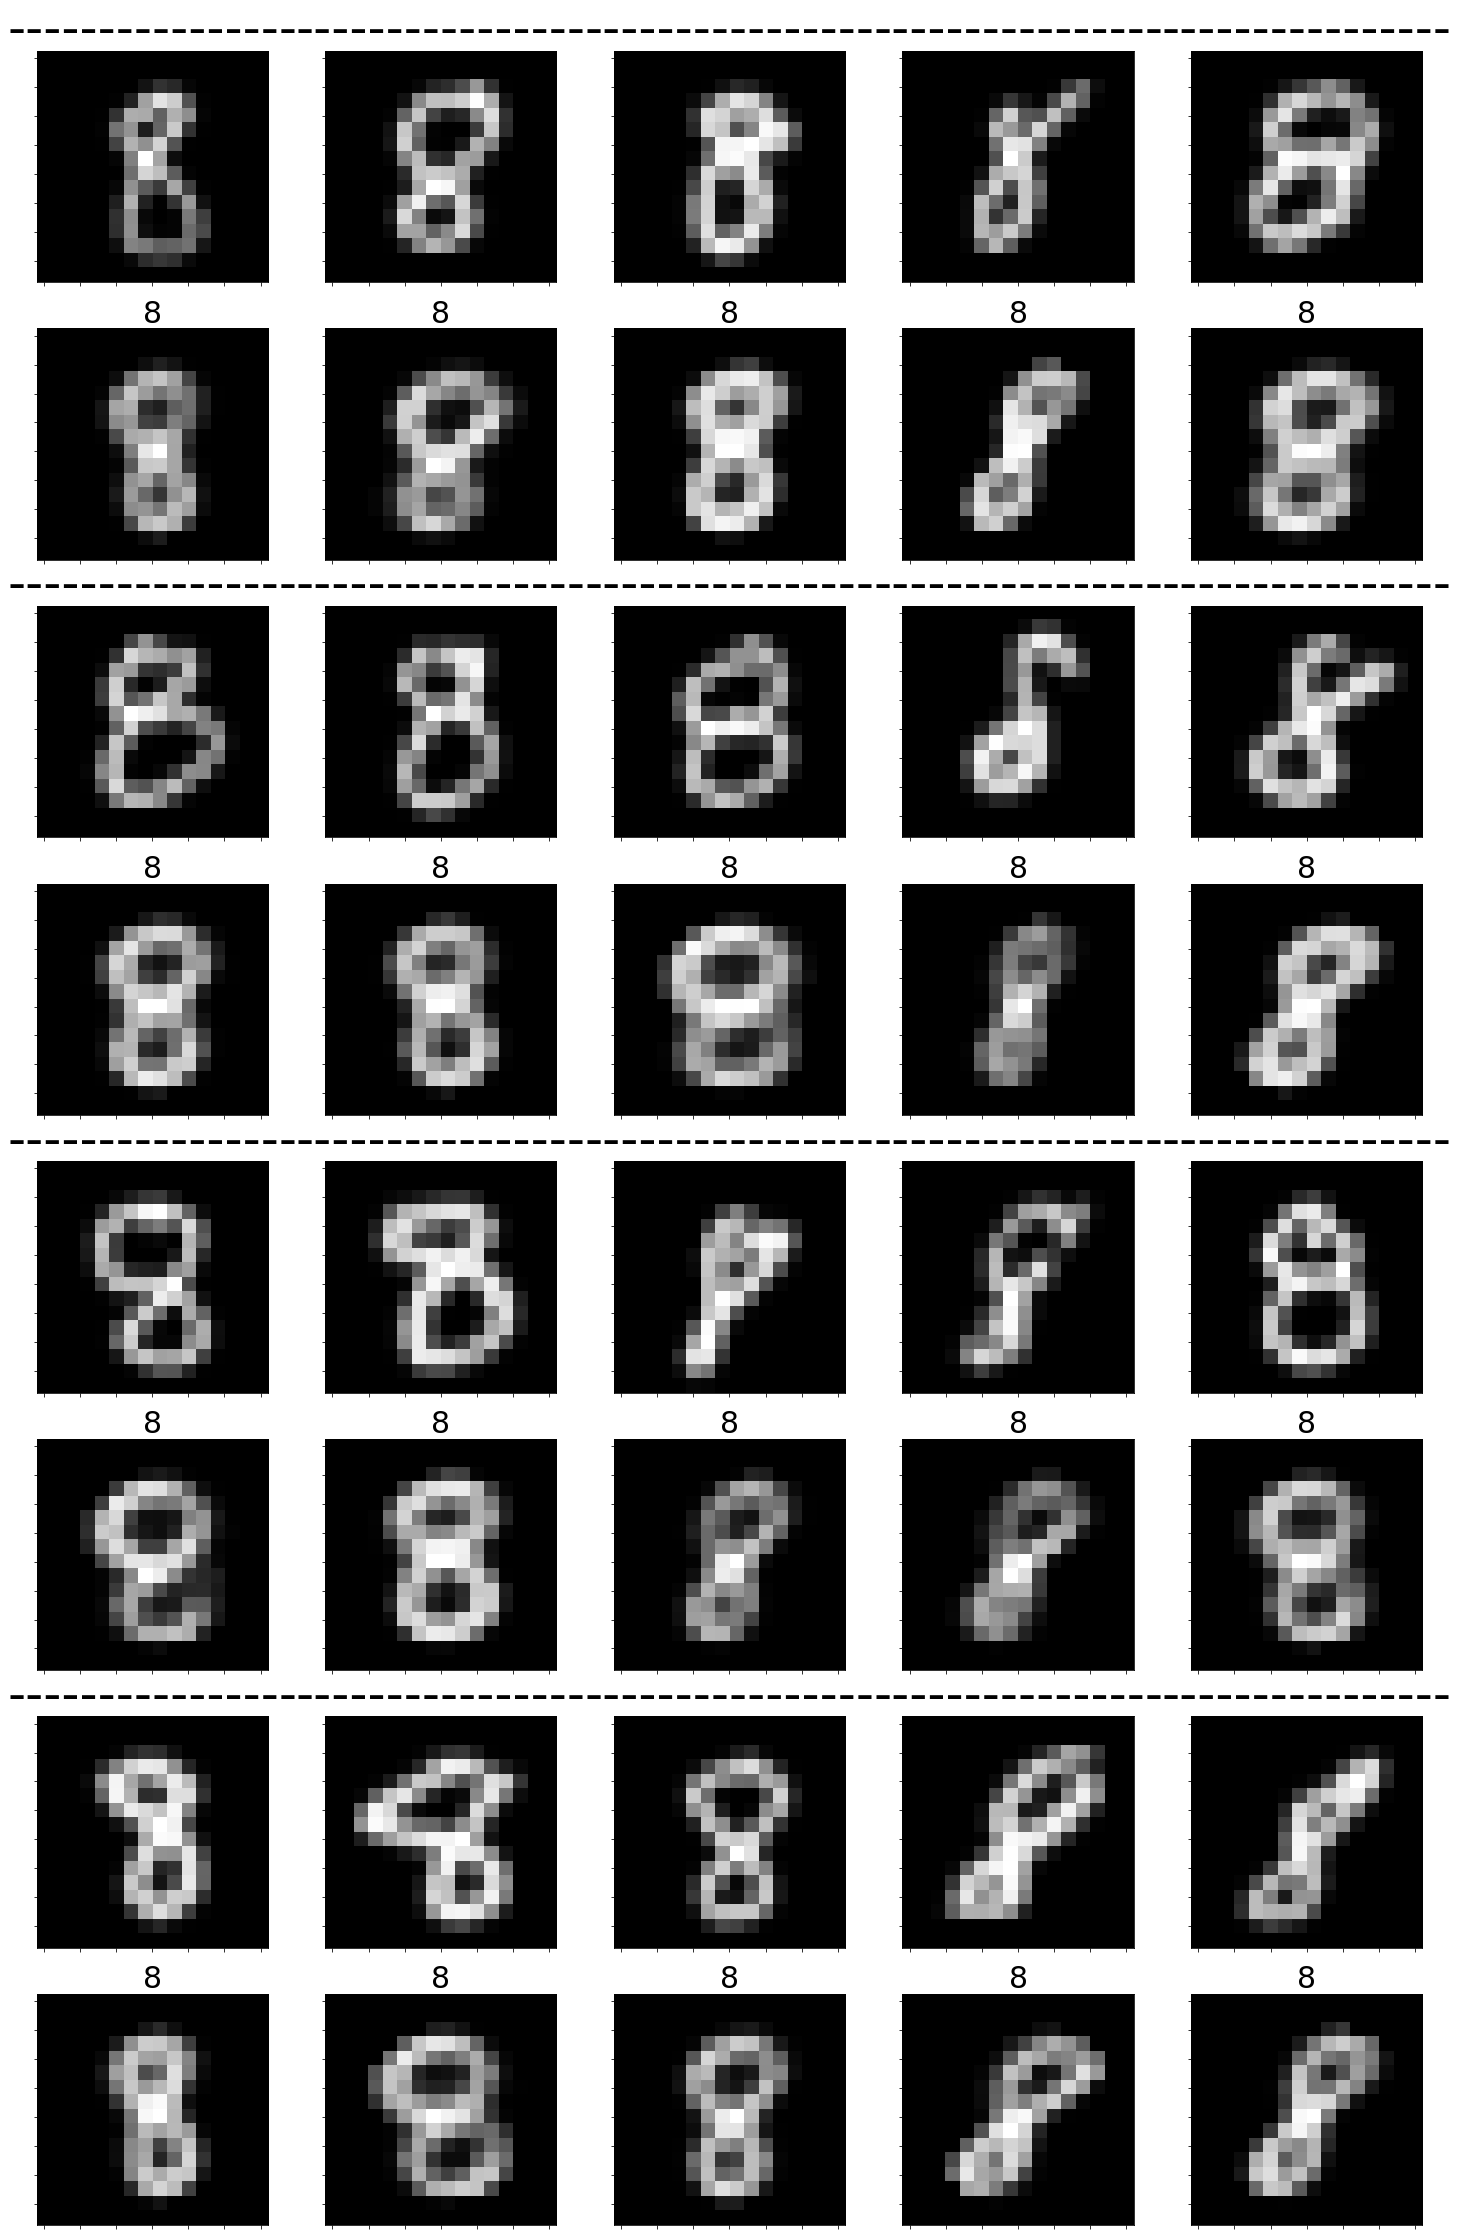

In [13]:
width = 5
display_num = 3
height = display_num * 2
test_batch = 512
testset = Dataset_MNIST(root, numbers, "val", transform["test"], each_datanum=each_datanum)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=test_batch, shuffle=False)
labels, inputs, outputs, _, latents = do_test_VAE(net, testloader, device, "eval")

fig = plt.figure(figsize=(5*width, 5*height), facecolor="w")
x = inputs
y = outputs
for i in range(display_num):
    for j in range(width):
        idx = width * j + i
        ax = fig.add_subplot(height, width, i*2*width+j+1)
        M = image_from_numpy(x[idx:idx+1])[0]
        ax.imshow(M)
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.set_title("----------------", fontsize=50)

        ax = fig.add_subplot(height, width, (i*2+1)*width+j+1)
        M = image_from_numpy(np.expand_dims(y[idx:idx+1], 0))[0]
        ax.imshow(M)
        ax.set_title(source_number, fontsize=30)
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

### Reconstructed Images
---
次に，`source_number`で設定した正常なクラス以外のクラス(異常なクラス)のデータにおける結果を見ていきます．

---

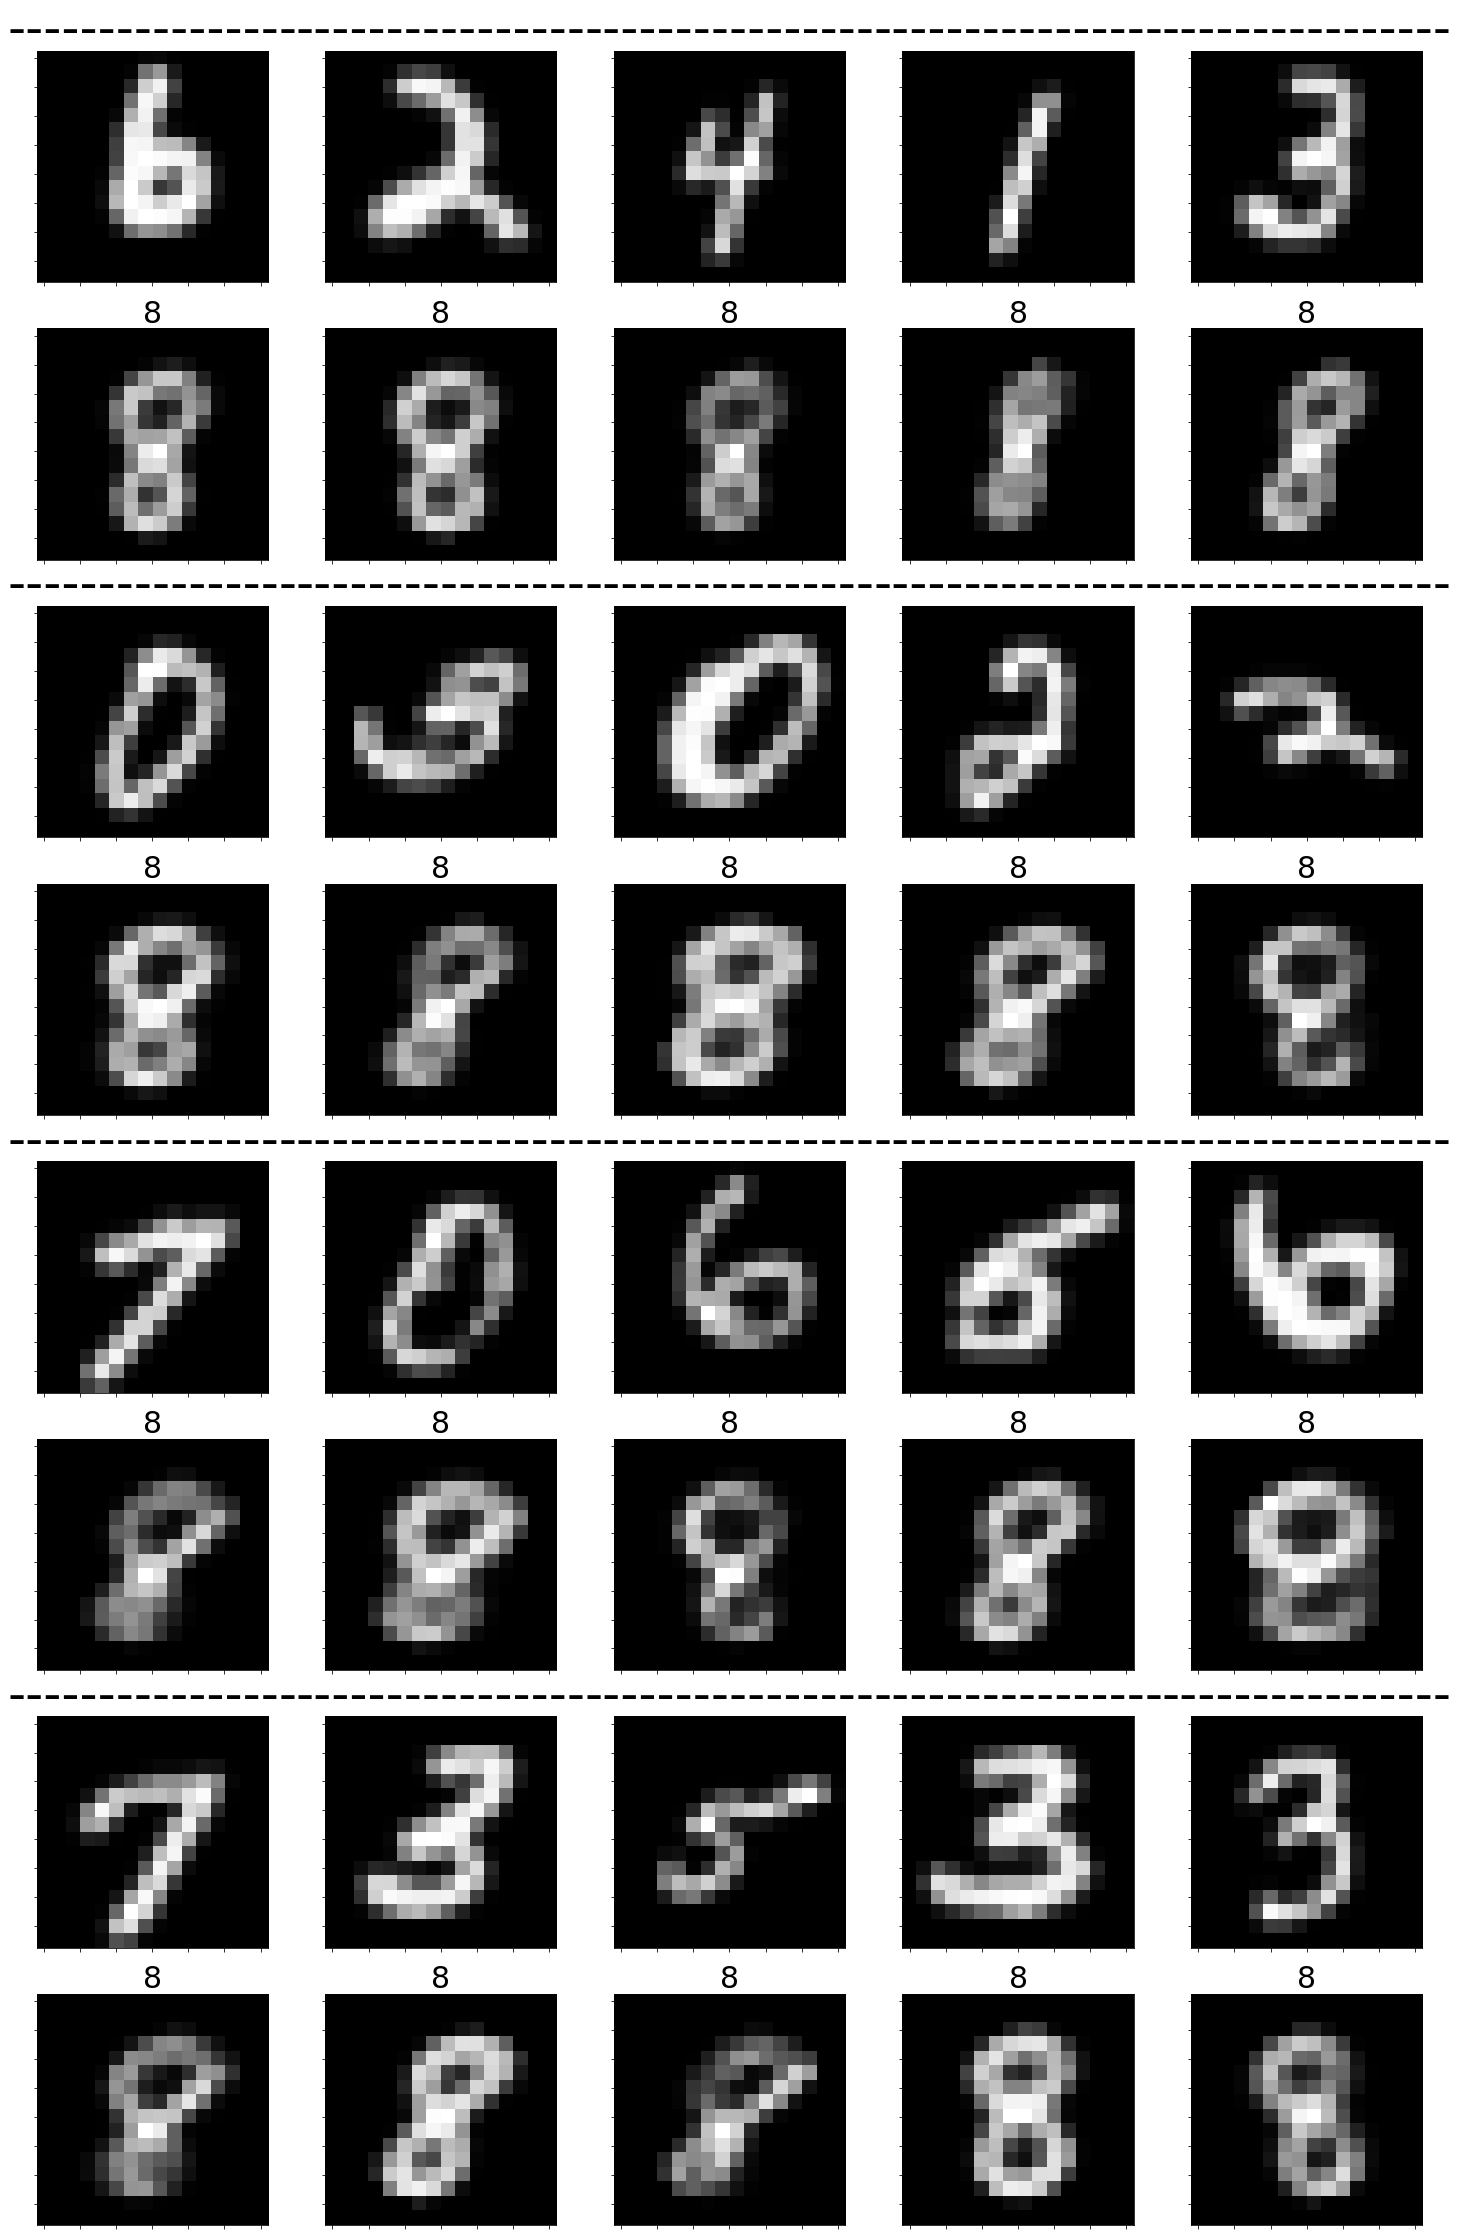

In [14]:
height = display_num * 2
width = 5

wrongnumbers = tuple(set(range(10)) - set([source_number]))
testset = Dataset_MNIST(root, wrongnumbers, "val", transform["test"], each_datanum=each_datanum)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=test_batch, shuffle=True)
labels, inputs, outputs, _, latents = do_test_VAE(net, testloader, device, "eval")

fig = plt.figure(figsize=(5*width, 5*height), facecolor="w")
x = inputs
y = outputs
for i in range(display_num):
    for j in range(width):
        idx = width * j + i
        ax = fig.add_subplot(height, width, i*2*width+j+1)
        M = image_from_numpy(x[idx:idx+1])[0]
        ax.imshow(M)
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.set_title("----------------", fontsize=50)

        ax = fig.add_subplot(height, width, (i*2+1)*width+j+1)
        M = image_from_numpy(np.expand_dims(y[idx:idx+1], 0))[0]
        ax.imshow(M)
        ax.set_title(source_number, fontsize=30)
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

---
---
---
問題1: 異常なクラスにおける再構成は失敗したはずです．これはエンコーダかデコーダ，どちらが原因と考えられますか．

Q1: 

---

Answer:

---
---

問題2: なぜ{エンコーダ,デコーダ}のせいで再構成は失敗したか．

Q2: 

---

Answer:

---
---
---

### Check the Losses of Each Class
---
全てのクラス合わせたデータセットで，それぞれのデータの損失（KL divergence lossとreconstruction loss）の分布を見ていきましょう．

---

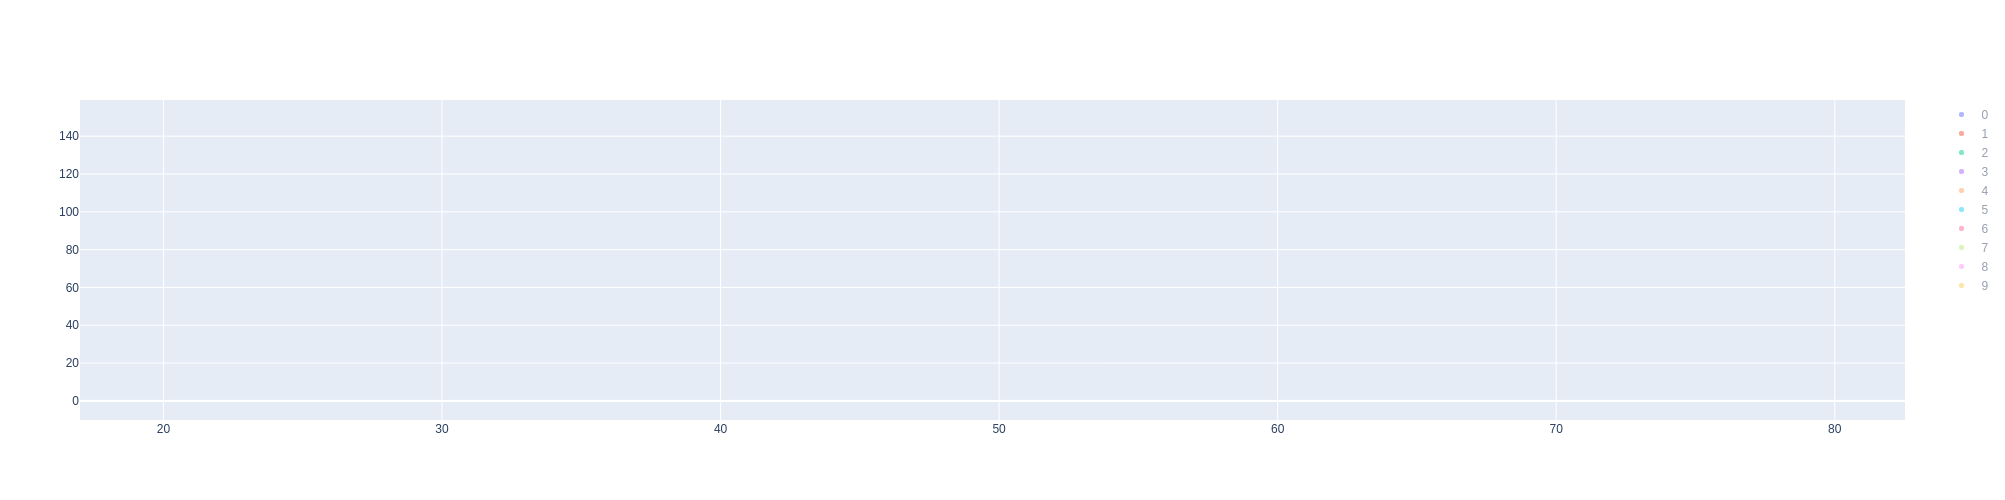

In [66]:
test_batch = 1
all_numbers = tuple(range(10))
testset = Dataset_MNIST(root, all_numbers, "val", transform["test"], each_datanum=each_datanum)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=test_batch, shuffle=False)

labels, inputs, outputs, losses, latents = do_test_VAE(net, testloader, device, "eval", losses_mean=False)
losses = np.array(losses)

trace = []
# ls = np.mean(np.square((inputs[:,0,:,:] - outputs)**2), axis=(1,2))
for i in range(len(all_numbers)):
#     _x = ls[labels==all_numbers[i]]
    _x = losses[labels==all_numbers[i]]
    trace.append(go.Scatter(x=_x, mode="markers", name=f"{all_numbers[i]}", 
                              marker = dict(size=5)))
layout = go.Layout(width=700, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

---
---
---
問題3: 正常クラスのデータと異常クラスのデータではどのような違いが現れましたか．

Q3: 

---

Answer:

---
---

問題4: そのような違いが現れた理由はなんですか．

Q4: 

---

Answer:

---
---

問題5: これを用いてどのように異常検知を行うことができますか．

Q5: 

---

Answer:

---
---
---